# GOAL
Find out if the 3-Tier response introduced in October 14, 2020 affected covid-19 case growth rate(https://www.bbc.co.uk/newsround/54509311).

# RESULTS + DISCUSSION
The UK Government introduced a 3-Tier response to covid containment on October 14, 2020.  Tier 1 restrictions were similar to existing restrictions nationwide.  Among other things, Tier 2 added more limits to indoor mixing, and Tier 3 added more limits to hospitality.  Then a national lockdown was declared on Nov 5, 2020 for a month.  (https://www.bbc.co.uk/newsround/54509311, https://www.bbc.co.uk/newsround/54768410 Acessed May 9 2021)

Although moving to Tier 2 and Tier 3 significantly decreased covid case growth rates from before the Tier introductions, Tier 2 only decreased weekly growth rates by 0.1 on average, whereas Tier 3 decreased covid growth rates by 0.6 on average.

# DATASETS

* Dates of tier introductions in LTLA (Local Tier Local Authority) regions in the UK until Dec 12, 2020.  Curated by Imperial College of London.
https://github.com/ImperialCollegeLondon/covid19model/blob/9fdc31b07078b271cdd3d092e00c98b482684e68/tiers/data/npis_23Mar_02Dec.csv

* New case count in each LTLA in the UK up until May 2021.  Curated by the coronavirus.data.gov.uk website.  https://coronavirus.data.gov.uk/details/cases.  Accessed May 10, 2021.

Due to limited time, we limited ourselves to the timeframe up until Dec 2020, in which we have well curated datasets.  Additional data on each the tier system Dec 2020 and the next national lockdown starting Jan 4, 2021 were available, but required manual parsing, and so were excluded.  We also assumed that the data from the datasets was accurate and did not do any validation against external sources, such as data available on PHE.  However, given enough time, we would.


# METHODS
Although the tiers were introduced and kept constant for a few days to a few weeks, there are many other factors that could affect the covid case growth rate during that time, such as fitter variants being introduced to a region.  Ideally, we would use a mathematical model to determine how those factors would change the growth rate.  Given the time contraints, we chose to limit our question to whether the tier response significantly affected the case growth rate, and perform quick statistical analysis.

From visual inspection of a few LTLAs, the drop of covid cases was minimal in Tier 2 compared to Tier 3.  Some LTLAs such as Birmingham stood out with increasing covid cases even after Tier 2 introduction, and stable covid cases during Tier 3.  We would expect that the same tier restrictions would have a different level of effect on different LTLAs, depending on factors specific to the LTLA such as population density, movement, total school aged etc.  This was one reason to try mixed models with LTLA as fixed effects as well as simpler models.

Unfortunately, none of the statistical models fit the data convincingly, which would indicate that we still need to account for other factors.  However, the best model was a Gaussian Mixed Model with LTLA as fixed effects.  

````Growth Rate ~ Tier + Days Since Tier Introduction + New Daily Cases | LTLA````


Due to reporting issues where weekend cases were not reported until Monday, and other issues where reporting may have been uneven, we smoothed out the New Daily Cases using a rolling 1 week average, ending on the reported day.  We tried using multiple versions of a response variable in our models.  One of then was the raw smoothed counts, and another was the 14-day case growth rate calculated as

````(smoothed cases today - smoothed cases 14 days ago)/smoothed cases 14 days ago````

We chose a 14-day growth period to coincide with the maximum reported incubation period of SARS-CoV-2.  (https://www.who.int/news-room/commentaries/detail/transmission-of-sars-cov-2-implications-for-infection-prevention-precautions, Accessed May 9 2021).  The idea was that the effects of government intervention would require at least 1 incubation period to affect the case rate.

We found that Tier 2 signifcantly decreased growth rate compared to Tier 1 by 0.9 (q=2.5e-122, Benjamini-Hochburg adjusted pvalues), and Tier 3 significantly decreased growth rate compared to Tier 3 by 0.4 (q=1.5e-10, Benjamini-Hochburg adjusted pvalues).



# Prerequisites:

Run Clean_Raw_Datasets.ipynb first to clean the raw datasets

In [59]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.stats as smstats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels import tools as smtools
from statsmodels.genmod.families.links import Log
from matplotlib.lines import Line2D
import scipy.stats

In [60]:
ICL_NPIS_CLEAN = "data/icl/clean/npis_23Mar_02Dec.csv"
GOV_UK_DAILY_CASE_LTLA_TIER_CLEAN = "data/gov_uk_icl/clean/gov_uk_ltla_tier_newCasesBySpecimenDate_2021-05-09.csv"

In [61]:
# https://www.cdc.gov/coronavirus/2019-ncov/hcp/clinical-guidance-management-patients.html
MEDIAN_INCUBATION_DAYS = 5
MAX_INCUBATION_DAYS = 14

# Read in Gov UK, Imperial College Dataset for Daily Cases by LTLA and Tier

In [62]:
case_ltla_tier_df = pd.read_csv(GOV_UK_DAILY_CASE_LTLA_TIER_CLEAN)
case_ltla_tier_df["date"] = pd.to_datetime(case_ltla_tier_df["date"])
case_ltla_tier_df["newCasesBySpecimenDateSmooth"] = case_ltla_tier_df["newCasesBySpecimenDateSmooth"].astype(int) 
case_ltla_tier_df

,ltla,date,tier,is_tier_change,d_since_tier_change,newCasesBySpecimenDateSmooth
0,Adur,2020-06-15,1,True,0,0
1,Adur,2020-06-16,1,False,1,0
2,Adur,2020-06-17,1,False,2,0
3,Adur,2020-06-18,1,False,3,0
4,Adur,2020-06-19,1,False,4,0
...,...,...,...,...,...,...
53005,York,2020-11-28,national_lockdown,False,23,23
53006,York,2020-11-29,national_lockdown,False,24,20
53007,York,2020-11-30,national_lockdown,False,25,19
53008,York,2020-12-01,national_lockdown,False,26,23


In [63]:
def first_case_count_at_tier_change(df):
    df["newCasesBySpecimenDateSmooth_at_tier_change"] = df.iloc[0]["newCasesBySpecimenDateSmooth"]
    return df
case_ltla_tier_df = case_ltla_tier_df.groupby(["ltla", "tier"]).apply(first_case_count_at_tier_change)
case_ltla_tier_df

,ltla,date,tier,is_tier_change,d_since_tier_change,newCasesBySpecimenDateSmooth,newCasesBySpecimenDateSmooth_at_tier_change
0,Adur,2020-06-15,1,True,0,0,0
1,Adur,2020-06-16,1,False,1,0,0
2,Adur,2020-06-17,1,False,2,0,0
3,Adur,2020-06-18,1,False,3,0,0
4,Adur,2020-06-19,1,False,4,0,0
...,...,...,...,...,...,...,...
53005,York,2020-11-28,national_lockdown,False,23,23,57
53006,York,2020-11-29,national_lockdown,False,24,20,57
53007,York,2020-11-30,national_lockdown,False,25,19,57
53008,York,2020-12-01,national_lockdown,False,26,23,57


In [64]:
# Now we calculate today's growth rate over the incubation period ending on today

# We set default value for now to zero.  ideally we would set to na, but it won't let us cast to float if we do.
case_ltla_tier_df["growth_rate"] = 0

case_ltla_tier_df["newCasesBySpecimenDateSmooth_lag14d"] = (case_ltla_tier_df
                                                               .shift(periods=MAX_INCUBATION_DAYS)
                                                               ["newCasesBySpecimenDateSmooth"])

case_ltla_tier_df.loc[case_ltla_tier_df["newCasesBySpecimenDateSmooth_lag14d"] != 0, "growth_rate"] = (
    (case_ltla_tier_df["newCasesBySpecimenDateSmooth"] - 
         case_ltla_tier_df["newCasesBySpecimenDateSmooth_lag14d"]) /
    case_ltla_tier_df["newCasesBySpecimenDateSmooth_lag14d"]
)

case_ltla_tier_df["growth_rate"] = case_ltla_tier_df["growth_rate"].astype(float)

case_ltla_tier_df

,ltla,date,tier,is_tier_change,d_since_tier_change,newCasesBySpecimenDateSmooth,newCasesBySpecimenDateSmooth_at_tier_change,growth_rate,newCasesBySpecimenDateSmooth_lag14d
0,Adur,2020-06-15,1,True,0,0,0,NaN,NaN
1,Adur,2020-06-16,1,False,1,0,0,NaN,NaN
2,Adur,2020-06-17,1,False,2,0,0,NaN,NaN
3,Adur,2020-06-18,1,False,3,0,0,NaN,NaN
4,Adur,2020-06-19,1,False,4,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
53005,York,2020-11-28,national_lockdown,False,23,23,57,-0.549020,51.0
53006,York,2020-11-29,national_lockdown,False,24,20,57,-0.615385,52.0
53007,York,2020-11-30,national_lockdown,False,25,19,57,-0.612245,49.0
53008,York,2020-12-01,national_lockdown,False,26,23,57,-0.500000,46.0


In [65]:
case_ltla_tier_df["growth_rate"].describe()

count    52996.000000
mean         0.402887
std          1.414096
min         -1.000000
25%         -0.185185
50%          0.000000
75%          0.750000
max         52.000000
Name: growth_rate, dtype: float64

In [66]:
def first_growth_rate_at_tier_change(df):
    df["growth_rate_at_tier_change"] = df.iloc[0]["growth_rate"]
    return df
case_ltla_tier_df = case_ltla_tier_df.groupby(["ltla", "tier"]).apply(first_growth_rate_at_tier_change)
case_ltla_tier_df

,ltla,date,tier,is_tier_change,d_since_tier_change,newCasesBySpecimenDateSmooth,newCasesBySpecimenDateSmooth_at_tier_change,growth_rate,newCasesBySpecimenDateSmooth_lag14d,growth_rate_at_tier_change
0,Adur,2020-06-15,1,True,0,0,0,NaN,NaN,NaN
1,Adur,2020-06-16,1,False,1,0,0,NaN,NaN,NaN
2,Adur,2020-06-17,1,False,2,0,0,NaN,NaN,NaN
3,Adur,2020-06-18,1,False,3,0,0,NaN,NaN,NaN
4,Adur,2020-06-19,1,False,4,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
53005,York,2020-11-28,national_lockdown,False,23,23,57,-0.549020,51.0,-0.491071
53006,York,2020-11-29,national_lockdown,False,24,20,57,-0.615385,52.0,-0.491071
53007,York,2020-11-30,national_lockdown,False,25,19,57,-0.612245,49.0,-0.491071
53008,York,2020-12-01,national_lockdown,False,26,23,57,-0.500000,46.0,-0.491071


In [67]:
# Find growth rate at the time of tier introduction.  Compare it to today's

case_ltla_tier_df["growth_rate_delta"] = case_ltla_tier_df["growth_rate"] - case_ltla_tier_df["growth_rate_at_tier_change"]

case_ltla_tier_df["growth_rate_delta"] = case_ltla_tier_df["growth_rate_delta"].astype(float)

case_ltla_tier_df

,ltla,date,tier,is_tier_change,d_since_tier_change,newCasesBySpecimenDateSmooth,newCasesBySpecimenDateSmooth_at_tier_change,growth_rate,newCasesBySpecimenDateSmooth_lag14d,growth_rate_at_tier_change,growth_rate_delta
0,Adur,2020-06-15,1,True,0,0,0,NaN,NaN,NaN,NaN
1,Adur,2020-06-16,1,False,1,0,0,NaN,NaN,NaN,NaN
2,Adur,2020-06-17,1,False,2,0,0,NaN,NaN,NaN,NaN
3,Adur,2020-06-18,1,False,3,0,0,NaN,NaN,NaN,NaN
4,Adur,2020-06-19,1,False,4,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
53005,York,2020-11-28,national_lockdown,False,23,23,57,-0.549020,51.0,-0.491071,-0.057948
53006,York,2020-11-29,national_lockdown,False,24,20,57,-0.615385,52.0,-0.491071,-0.124313
53007,York,2020-11-30,national_lockdown,False,25,19,57,-0.612245,49.0,-0.491071,-0.121173
53008,York,2020-12-01,national_lockdown,False,26,23,57,-0.500000,46.0,-0.491071,-0.008929


In [68]:
case_ltla_tier_df["growth_rate_delta"].describe()

count    52867.000000
mean         1.025870
std          1.588719
min         -5.150611
25%          0.000000
50%          0.974359
75%          1.444444
max         53.000000
Name: growth_rate_delta, dtype: float64

We know that all ltlas entered tier 1 and national lockdown at the same time.
But how many entered tier 2 and tier 3?   

139, 43 respectively.  Too many to plot, so we just arbitrarily see a few that were in both, to see if there is a huge escalation that warranted Tier 2 -> Tier 3.

Also plot some that stayed in Tier 2 to see if the cases went down.

In [69]:
# total ltlas that were in tier 2 at any point
case_ltla_tier_df[case_ltla_tier_df["tier"] == "2"]["ltla"].nunique()

140

In [70]:
# total ltlas that were in tier 3 at any point
case_ltla_tier_df[case_ltla_tier_df["tier"] == "3"]["ltla"].nunique()

43

In [71]:
# total ltlas that were in tier 2 and tier 3, or just tier 3 at any point
high_tier_df = case_ltla_tier_df[
    (case_ltla_tier_df["ltla"].isin(case_ltla_tier_df[case_ltla_tier_df["tier"] == "2"]["ltla"])  &
    case_ltla_tier_df["ltla"].isin(case_ltla_tier_df[case_ltla_tier_df["tier"] == "3"]["ltla"]))
    
    |
    
    case_ltla_tier_df["ltla"].isin(case_ltla_tier_df[case_ltla_tier_df["tier"] == "3"]["ltla"])

]
display(high_tier_df["ltla"].unique())
display(high_tier_df["ltla"].nunique())

array(['Ashfield', 'Barnsley', 'Bassetlaw', 'Blackburn with Darwen',
       'Blackpool', 'Bolton', 'Broxtowe', 'Burnley', 'Bury', 'Chorley',
       'Doncaster', 'Fylde', 'Gedling', 'Halton', 'Hyndburn', 'Knowsley',
       'Lancaster', 'Liverpool', 'Manchester', 'Mansfield',
       'Newark and Sherwood', 'Nottingham', 'Oldham', 'Pendle', 'Preston',
       'Ribble Valley', 'Rochdale', 'Rossendale', 'Rotherham',
       'Rushcliffe', 'Salford', 'Sefton', 'Sheffield', 'South Ribble',
       'St. Helens', 'Stockport', 'Tameside', 'Trafford', 'Warrington',
       'West Lancashire', 'Wigan', 'Wirral', 'Wyre'], dtype=object)

43

Get a random selection of samples with varying days since tier change

In [72]:

display(high_tier_df[(high_tier_df["d_since_tier_change"] < 20) &
                                  high_tier_df["tier"].isin(["2", "3"])]["ltla"].nunique())
display(high_tier_df[(high_tier_df["d_since_tier_change"] >= 20) &
                                  high_tier_df["tier"].isin(["2", "3"])]["ltla"].nunique())

43

6

In [73]:
high_tier_ltlas = np.append(
    np.random.choice(high_tier_df[(high_tier_df["d_since_tier_change"] < 20) &
                                  high_tier_df["tier"].isin(["2", "3"])]["ltla"].unique(), 8),
    np.random.choice(high_tier_df[(high_tier_df["d_since_tier_change"] >= 20) &
                                  high_tier_df["tier"].isin(["2", "3"])]["ltla"].unique(), 8)
)
high_tier_ltlas

array(['Sefton', 'Bolton', 'Hyndburn', 'Blackpool', 'West Lancashire',
       'Salford', 'Manchester', 'Newark and Sherwood', 'Liverpool',
       'Wirral', 'St. Helens', 'Halton', 'Sefton', 'Sefton', 'Wirral',
       'St. Helens'], dtype=object)

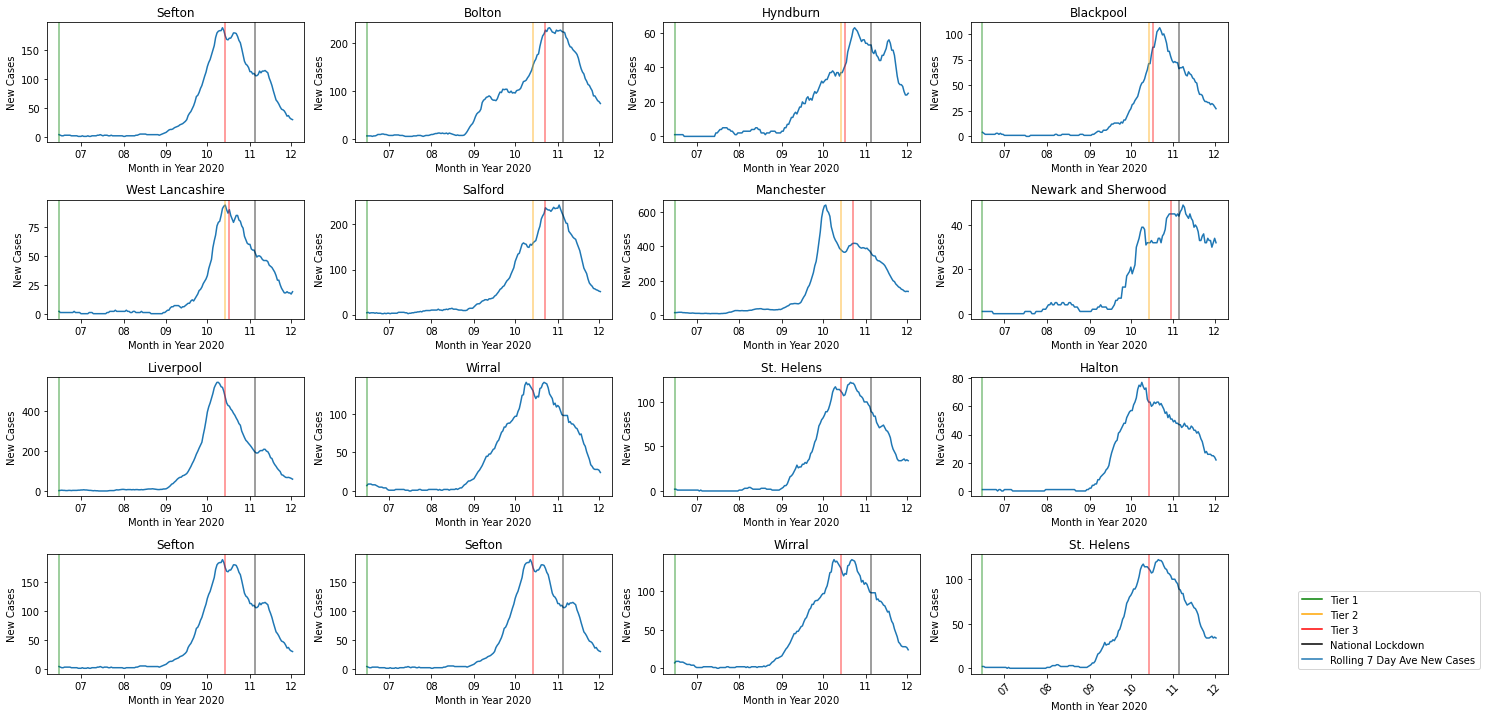

In [74]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))


for i, ax in enumerate(axs.flatten()):  
    
    high_tier_ltla_df = high_tier_df[high_tier_df["ltla"] == high_tier_ltlas[i]]
    
    ax.plot(high_tier_ltla_df["date"], high_tier_ltla_df["newCasesBySpecimenDateSmooth"], 
            label="Rolling 7 day ave of new cases")
    
    for tierchange_date in high_tier_ltla_df[high_tier_ltla_df["is_tier_change"] & 
                                             (high_tier_ltla_df["tier"] == "1")]["date"]:
        ax.axvline(tierchange_date, color = "green", alpha=0.5, label="Tier 1")

    for tierchange_date in high_tier_ltla_df[high_tier_ltla_df["is_tier_change"] & 
                                             (high_tier_ltla_df["tier"] == "2")]["date"]:
        ax.axvline(tierchange_date, color = "orange", alpha=0.5, label="Tier 2")

    for tierchange_date in high_tier_ltla_df[high_tier_ltla_df["is_tier_change"] & 
                                             (high_tier_ltla_df["tier"] == "3")]["date"]:
        ax.axvline(tierchange_date, color = "red", alpha=0.5, label="Tier 3")

    for tierchange_date in high_tier_ltla_df[high_tier_ltla_df["is_tier_change"] & 
                                             (high_tier_ltla_df["tier"] == "national_lockdown")]["date"]:
        ax.axvline(tierchange_date, color = "black", alpha=0.5, label="National Lockdown")

    ax.set_xticks(["2020-07-01", "2020-08-01", "2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01"])
    ax.set_xticklabels(["07", "08", "09", "10", "11", "12"])
    ax.set_xlabel("Month in Year 2020")
    ax.set_ylabel("New Cases")
    ax.set_title(high_tier_ltlas[i])

plt.subplots_adjust(wspace = 0.5)

legend_elements = [Line2D([0], [0], color='green', label='Tier 1'),
                   Line2D([0], [0], color='orange', label='Tier 2'),
                   Line2D([0], [0], color='red', label='Tier 3'),
                   Line2D([0], [0], color='black', label='National Lockdown'),
                   Line2D([0], [0], color='#1f77b4', label='Rolling 7 Day Ave New Cases')
                  ]
lgd = plt.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(2, 0))

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [75]:
# total ltlas that were in tier 2 and tier 3 at any point
mid_tier_df = case_ltla_tier_df[
    case_ltla_tier_df["ltla"].isin(case_ltla_tier_df[case_ltla_tier_df["tier"] == "2"]["ltla"])  &
    ~case_ltla_tier_df["ltla"].isin(case_ltla_tier_df[case_ltla_tier_df["tier"] == "3"]["ltla"])

]
display(mid_tier_df["ltla"].unique())
display(mid_tier_df["ltla"].nunique())

array(['Amber Valley', 'Barking and Dagenham', 'Barnet',
       'Barrow-in-Furness', 'Basildon', 'Bexley', 'Birmingham',
       'Bolsover', 'Bradford', 'Braintree', 'Brent', 'Brentwood',
       'Bromley', 'Calderdale', 'Camden', 'Cannock Chase', 'Carlisle',
       'Castle Point', 'Charnwood', 'Chelmsford', 'Cheshire East',
       'Cheshire West and Chester', 'Chesterfield', 'City of London',
       'Colchester', 'County Durham', 'Coventry', 'Croydon', 'Darlington',
       'Derby', 'Derbyshire Dales', 'Dudley', 'Ealing',
       'East Riding of Yorkshire', 'East Staffordshire', 'Elmbridge',
       'Enfield', 'Epping Forest', 'Erewash', 'Gateshead', 'Greenwich',
       'Hammersmith and Fulham', 'Haringey', 'Harlow', 'Harrow',
       'Hartlepool', 'Havering', 'High Peak', 'Hillingdon', 'Hounslow',
       'Islington', 'Kensington and Chelsea',
       'Kingston upon Hull, City of', 'Kingston upon Thames', 'Kirklees',
       'Lambeth', 'Leeds', 'Leicester', 'Lewisham', 'Lichfield', 'Luton',
 

103

In [76]:
mid_tier_ltlas = np.append(
    np.random.choice(mid_tier_df[(mid_tier_df["d_since_tier_change"] < 20) &
                                  mid_tier_df["tier"].isin(["2", "3"])]["ltla"].unique(), 8),
    np.random.choice(mid_tier_df[(mid_tier_df["d_since_tier_change"] >= 20) &
                                  mid_tier_df["tier"].isin(["2", "3"])]["ltla"].unique(), 8)
)
mid_tier_ltlas

array(['Chesterfield', 'Epping Forest', 'Harlow', 'South Staffordshire',
       'Enfield', 'Sandwell', 'Enfield', 'Luton', 'Middlesbrough',
       'Gateshead', 'Gateshead', 'Wolverhampton', 'Wolverhampton',
       'Wakefield', 'Walsall', 'Leicester'], dtype=object)

In [77]:
display(mid_tier_df[(mid_tier_df["d_since_tier_change"] < 20) &
                                  mid_tier_df["tier"].isin(["2", "3"])]["ltla"].nunique())
display(mid_tier_df[(mid_tier_df["d_since_tier_change"] >= 20) &
                                  mid_tier_df["tier"].isin(["2", "3"])]["ltla"].nunique())

103

26

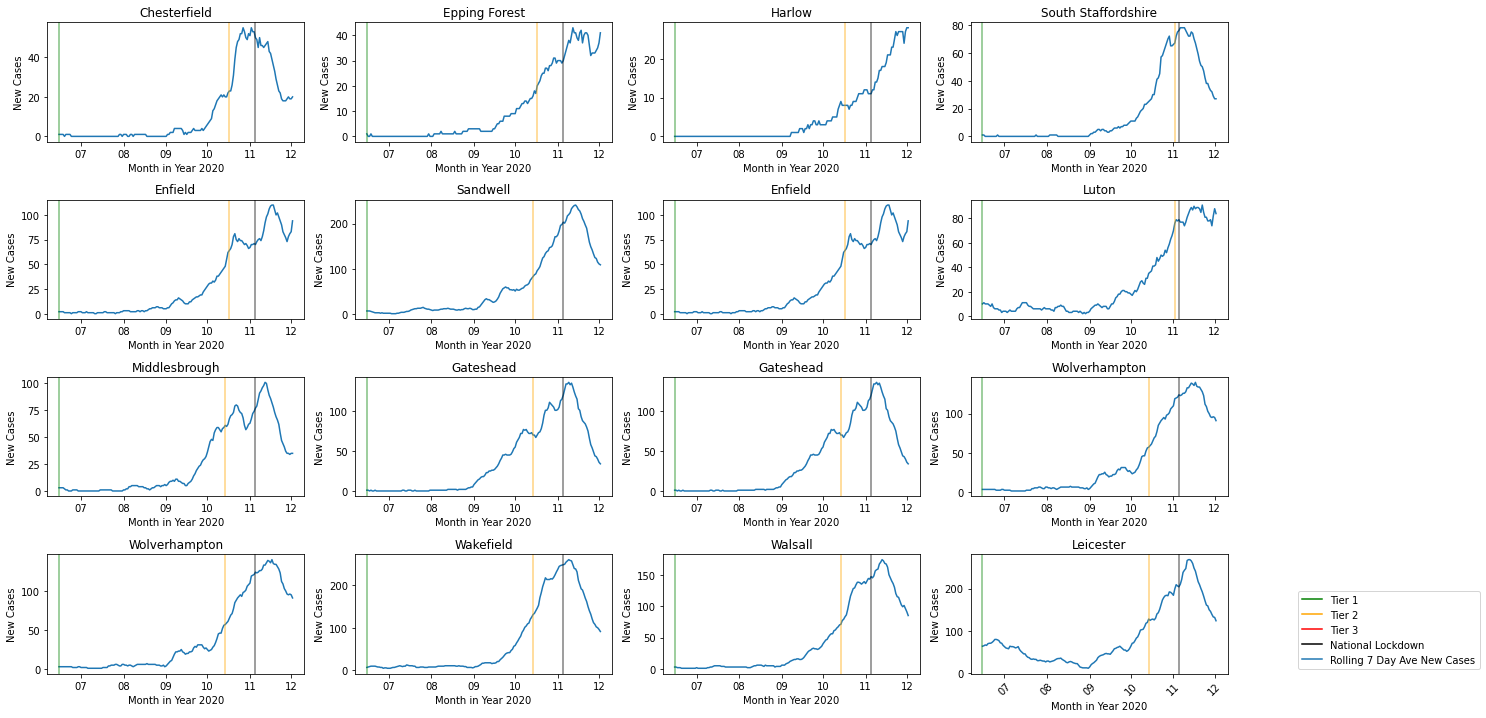

In [78]:


fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))


for i, ax in enumerate(axs.flatten()):  
    
    mid_tier_ltla_df = mid_tier_df[mid_tier_df["ltla"] == mid_tier_ltlas[i]]
    
    ax.plot(mid_tier_ltla_df["date"], mid_tier_ltla_df["newCasesBySpecimenDateSmooth"], 
            label="Rolling 7 day ave of new cases")
    
    for tierchange_date in mid_tier_ltla_df[mid_tier_ltla_df["is_tier_change"] & 
                                             (mid_tier_ltla_df["tier"] == "1")]["date"]:
        ax.axvline(tierchange_date, color = "green", alpha=0.5, label="Tier 1")

    for tierchange_date in mid_tier_ltla_df[mid_tier_ltla_df["is_tier_change"] & 
                                             (mid_tier_ltla_df["tier"] == "2")]["date"]:
        ax.axvline(tierchange_date, color = "orange", alpha=0.5, label="Tier 2")

    for tierchange_date in mid_tier_ltla_df[mid_tier_ltla_df["is_tier_change"] & 
                                             (mid_tier_ltla_df["tier"] == "3")]["date"]:
        ax.axvline(tierchange_date, color = "red", alpha=0.5, label="Tier 3")

    for tierchange_date in mid_tier_ltla_df[mid_tier_ltla_df["is_tier_change"] & 
                                             (mid_tier_ltla_df["tier"] == "national_lockdown")]["date"]:
        ax.axvline(tierchange_date, color = "black", alpha=0.5, label="National Lockdown")

    ax.set_xticks(["2020-07-01", "2020-08-01", "2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01"])
    ax.set_xticklabels(["07", "08", "09", "10", "11", "12"])
    ax.set_xlabel("Month in Year 2020")
    ax.set_ylabel("New Cases")
    ax.set_title(mid_tier_ltlas[i])

plt.subplots_adjust(wspace = 0.5)

legend_elements = [Line2D([0], [0], color='green', label='Tier 1'),
                   Line2D([0], [0], color='orange', label='Tier 2'),
                   Line2D([0], [0], color='red', label='Tier 3'),
                   Line2D([0], [0], color='black', label='National Lockdown'),
                   Line2D([0], [0], color='#1f77b4', label='Rolling 7 Day Ave New Cases')
                  ]
lgd = plt.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(2, 0))

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

From preliminary inspection, growth rate slows down  with Tier 2 introduction , and even more with Tier 3 introduction.  There are still some anomolies like Manchester where growth rate increases with Tier 2 and only mildly drops with Tier 3.  We'll need to do some additional statistical analysis to figure out the trend over all the LTLAs.

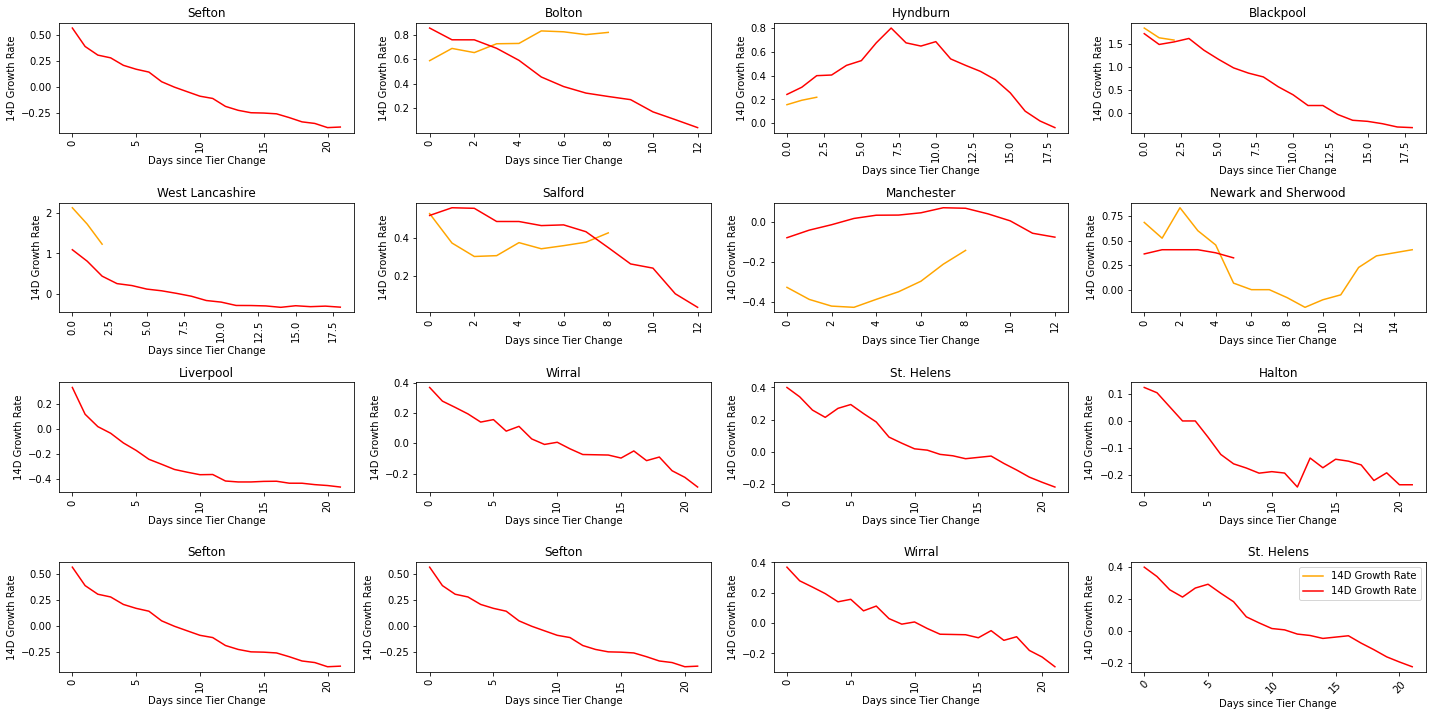

In [79]:

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))


for i, ax in enumerate(axs.flatten()):  
    
    high_tier_ltla_df = high_tier_df[high_tier_df["ltla"] == high_tier_ltlas[i]]
    
    ax.plot(high_tier_ltla_df[high_tier_ltla_df["tier"] == "2"]["d_since_tier_change"], 
            high_tier_ltla_df[high_tier_ltla_df["tier"] == "2"]["growth_rate"], 
            label="14D Growth Rate", color="orange")
    
    ax.plot(high_tier_ltla_df[high_tier_ltla_df["tier"] == "3"]["d_since_tier_change"], 
            high_tier_ltla_df[high_tier_ltla_df["tier"] == "3"]["growth_rate"], 
            label="14D Growth Rate", color="red")
    

    ax.set_xlabel("Days since Tier Change")
    ax.set_ylabel("14D Growth Rate")
    ax.set_title(high_tier_ltlas[i])
    ax.tick_params(axis='x', labelrotation=90 ) 

plt.subplots_adjust(wspace = 0.5)

plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

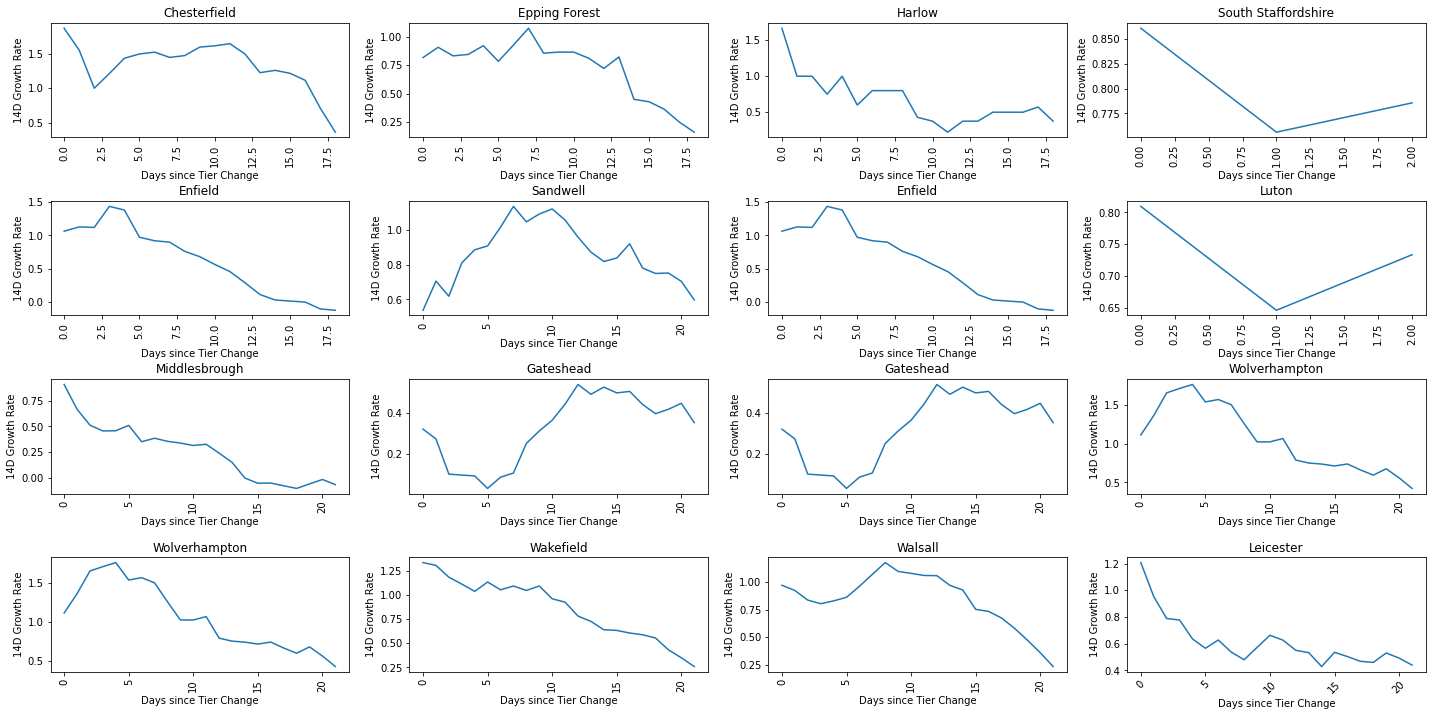

In [80]:

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))


for i, ax in enumerate(axs.flatten()):  
    
    mid_tier_ltla_df = mid_tier_df[mid_tier_df["ltla"] == mid_tier_ltlas[i]]
    
    ax.plot(mid_tier_ltla_df[mid_tier_ltla_df["tier"] == "2"]["d_since_tier_change"], 
            mid_tier_ltla_df[mid_tier_ltla_df["tier"] == "2"]["growth_rate"], 
            label="14D Growth Rate")
    

    ax.set_xlabel("Days since Tier Change")
    ax.set_ylabel("14D Growth Rate")
    ax.set_title(mid_tier_ltlas[i])
    ax.tick_params(axis='x', labelrotation=90 ) 

plt.subplots_adjust(wspace = 0.5)


plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

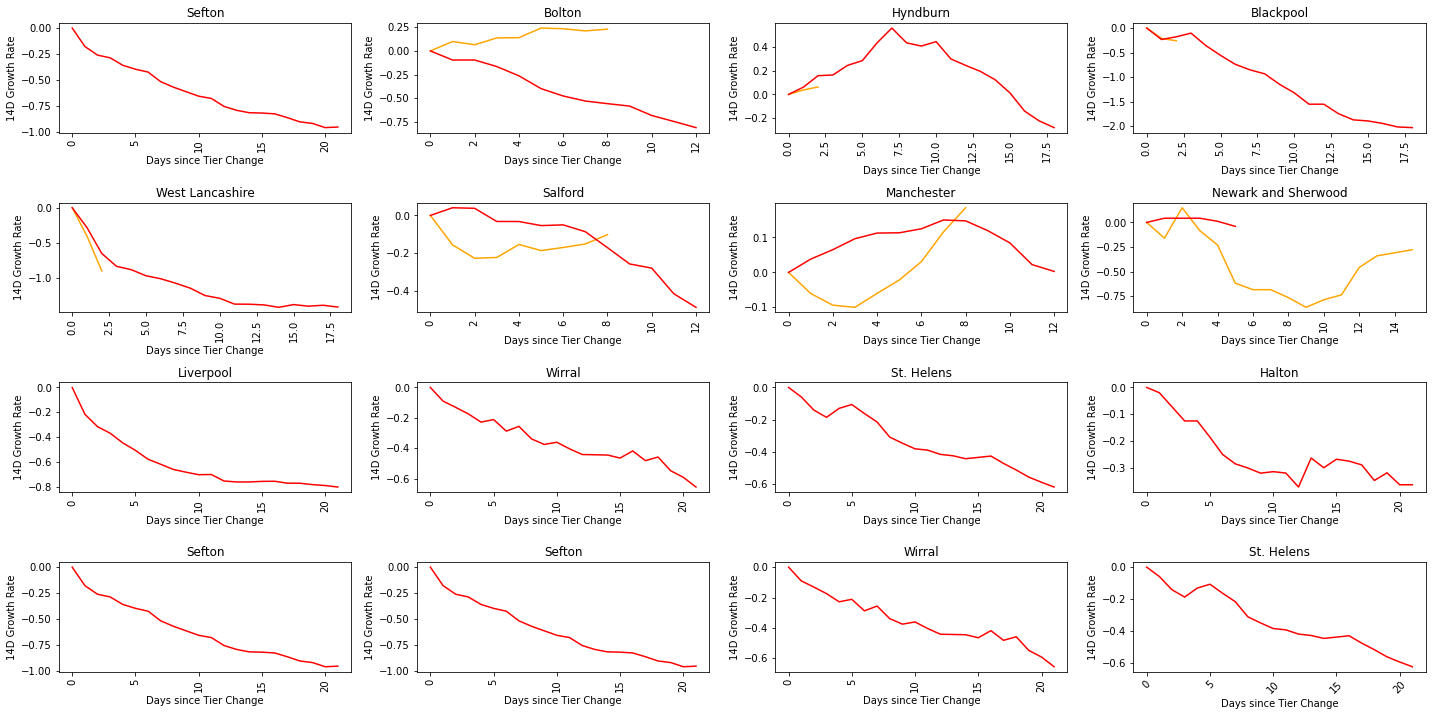

In [81]:

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))


for i, ax in enumerate(axs.flatten()):  
    
    high_tier_ltla_df = high_tier_df[high_tier_df["ltla"] == high_tier_ltlas[i]]
    
    ax.plot(high_tier_ltla_df[high_tier_ltla_df["tier"] == "2"]["d_since_tier_change"], 
            high_tier_ltla_df[high_tier_ltla_df["tier"] == "2"]["growth_rate_delta"], 
            label="14D Growth Rate", color="orange")
    
    ax.plot(high_tier_ltla_df[high_tier_ltla_df["tier"] == "3"]["d_since_tier_change"], 
            high_tier_ltla_df[high_tier_ltla_df["tier"] == "3"]["growth_rate_delta"], 
            label="14D Growth Rate", color="red")
    

    ax.set_xlabel("Days since Tier Change")
    ax.set_ylabel("14D Growth Rate")
    ax.set_title(high_tier_ltlas[i])
    ax.tick_params(axis='x', labelrotation=90 ) 

plt.subplots_adjust(wspace = 0.5)


plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [82]:
filt_data = case_ltla_tier_df.copy().loc[
                         ~case_ltla_tier_df["newCasesBySpecimenDateSmooth"].isna() &
                         (~case_ltla_tier_df["newCasesBySpecimenDateSmooth_lag14d"].isna()) &
                         ~case_ltla_tier_df["newCasesBySpecimenDateSmooth_lag14d"].isna() &
                         ~case_ltla_tier_df["d_since_tier_change"].isna() &
                         ~case_ltla_tier_df["growth_rate"].isna() &
                         ~case_ltla_tier_df["tier"].isna() &
                         ~case_ltla_tier_df["newCasesBySpecimenDateSmooth_at_tier_change"].isna()
]
filt_data

,ltla,date,tier,is_tier_change,d_since_tier_change,newCasesBySpecimenDateSmooth,newCasesBySpecimenDateSmooth_at_tier_change,growth_rate,newCasesBySpecimenDateSmooth_lag14d,growth_rate_at_tier_change,growth_rate_delta
14,Adur,2020-06-29,1,False,14,0,0,0.000000,0.0,NaN,NaN
15,Adur,2020-06-30,1,False,15,0,0,0.000000,0.0,NaN,NaN
16,Adur,2020-07-01,1,False,16,0,0,0.000000,0.0,NaN,NaN
17,Adur,2020-07-02,1,False,17,0,0,0.000000,0.0,NaN,NaN
18,Adur,2020-07-03,1,False,18,0,0,0.000000,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
53005,York,2020-11-28,national_lockdown,False,23,23,57,-0.549020,51.0,-0.491071,-0.057948
53006,York,2020-11-29,national_lockdown,False,24,20,57,-0.615385,52.0,-0.491071,-0.124313
53007,York,2020-11-30,national_lockdown,False,25,19,57,-0.612245,49.0,-0.491071,-0.121173
53008,York,2020-12-01,national_lockdown,False,26,23,57,-0.500000,46.0,-0.491071,-0.008929


We note that the distribution of the growth rate is left skewed with a long right tail.  Since there are negative values, we can't use a gamma distribution, which would help fix the skew.

In [83]:
filt_growth_rate_data = case_ltla_tier_df.loc[
                         ~case_ltla_tier_df["newCasesBySpecimenDateSmooth"].isna() &
                         ~case_ltla_tier_df["newCasesBySpecimenDateSmooth_lag14d"].isna() &
                         (case_ltla_tier_df["newCasesBySpecimenDateSmooth_lag14d"] != 0 ) &
                         ~case_ltla_tier_df["d_since_tier_change"].isna() &
                         ~case_ltla_tier_df["growth_rate"].isna() &
                         ~case_ltla_tier_df["tier"].isna() &
                         ~case_ltla_tier_df["newCasesBySpecimenDateSmooth_at_tier_change"].isna()
].copy()
filt_growth_rate_data

,ltla,date,tier,is_tier_change,d_since_tier_change,newCasesBySpecimenDateSmooth,newCasesBySpecimenDateSmooth_at_tier_change,growth_rate,newCasesBySpecimenDateSmooth_lag14d,growth_rate_at_tier_change,growth_rate_delta
94,Adur,2020-09-17,1,False,94,2,0,1.000000,1.0,NaN,NaN
95,Adur,2020-09-18,1,False,95,1,0,0.000000,1.0,NaN,NaN
96,Adur,2020-09-19,1,False,96,2,0,1.000000,1.0,NaN,NaN
97,Adur,2020-09-20,1,False,97,1,0,0.000000,1.0,NaN,NaN
98,Adur,2020-09-21,1,False,98,2,0,1.000000,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
53005,York,2020-11-28,national_lockdown,False,23,23,57,-0.549020,51.0,-0.491071,-0.057948
53006,York,2020-11-29,national_lockdown,False,24,20,57,-0.615385,52.0,-0.491071,-0.124313
53007,York,2020-11-30,national_lockdown,False,25,19,57,-0.612245,49.0,-0.491071,-0.121173
53008,York,2020-12-01,national_lockdown,False,26,23,57,-0.500000,46.0,-0.491071,-0.008929


In [84]:
filt_growth_rate_delta_data = case_ltla_tier_df.loc[
                         ~case_ltla_tier_df["newCasesBySpecimenDateSmooth"].isna() &
                         ~case_ltla_tier_df["d_since_tier_change"].isna() &
                         ~case_ltla_tier_df["growth_rate"].isna() &
                         ~case_ltla_tier_df["growth_rate_delta"].isna() &
                         ~case_ltla_tier_df["tier"].isna() &
                         ~case_ltla_tier_df["newCasesBySpecimenDateSmooth_at_tier_change"].isna()
].copy()
filt_growth_rate_delta_data

,ltla,date,tier,is_tier_change,d_since_tier_change,newCasesBySpecimenDateSmooth,newCasesBySpecimenDateSmooth_at_tier_change,growth_rate,newCasesBySpecimenDateSmooth_lag14d,growth_rate_at_tier_change,growth_rate_delta
143,Adur,2020-11-05,national_lockdown,True,0,5,5,0.666667,3.0,0.666667,0.000000
144,Adur,2020-11-06,national_lockdown,False,1,6,5,0.500000,4.0,0.666667,-0.166667
145,Adur,2020-11-07,national_lockdown,False,2,6,5,0.200000,5.0,0.666667,-0.466667
146,Adur,2020-11-08,national_lockdown,False,3,7,5,0.400000,5.0,0.666667,-0.266667
147,Adur,2020-11-09,national_lockdown,False,4,6,5,0.000000,6.0,0.666667,-0.666667
...,...,...,...,...,...,...,...,...,...,...,...
53005,York,2020-11-28,national_lockdown,False,23,23,57,-0.549020,51.0,-0.491071,-0.057948
53006,York,2020-11-29,national_lockdown,False,24,20,57,-0.615385,52.0,-0.491071,-0.124313
53007,York,2020-11-30,national_lockdown,False,25,19,57,-0.612245,49.0,-0.491071,-0.121173
53008,York,2020-12-01,national_lockdown,False,26,23,57,-0.500000,46.0,-0.491071,-0.008929


In [85]:
filt_case_data = case_ltla_tier_df.loc[
                         ~case_ltla_tier_df["newCasesBySpecimenDateSmooth"].isna() &
                         ~case_ltla_tier_df["newCasesBySpecimenDateSmooth_lag14d"].isna() &
                         ~case_ltla_tier_df["d_since_tier_change"].isna() &
                         ~case_ltla_tier_df["tier"].isna() &
                         ~case_ltla_tier_df["newCasesBySpecimenDateSmooth_at_tier_change"].isna()
].copy()
filt_case_data

,ltla,date,tier,is_tier_change,d_since_tier_change,newCasesBySpecimenDateSmooth,newCasesBySpecimenDateSmooth_at_tier_change,growth_rate,newCasesBySpecimenDateSmooth_lag14d,growth_rate_at_tier_change,growth_rate_delta
14,Adur,2020-06-29,1,False,14,0,0,0.000000,0.0,NaN,NaN
15,Adur,2020-06-30,1,False,15,0,0,0.000000,0.0,NaN,NaN
16,Adur,2020-07-01,1,False,16,0,0,0.000000,0.0,NaN,NaN
17,Adur,2020-07-02,1,False,17,0,0,0.000000,0.0,NaN,NaN
18,Adur,2020-07-03,1,False,18,0,0,0.000000,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
53005,York,2020-11-28,national_lockdown,False,23,23,57,-0.549020,51.0,-0.491071,-0.057948
53006,York,2020-11-29,national_lockdown,False,24,20,57,-0.615385,52.0,-0.491071,-0.124313
53007,York,2020-11-30,national_lockdown,False,25,19,57,-0.612245,49.0,-0.491071,-0.121173
53008,York,2020-12-01,national_lockdown,False,26,23,57,-0.500000,46.0,-0.491071,-0.008929


# What is Drop in Case 2 weeks after Tier 2, Tier 3 Introduced?

In [86]:
filt_growth_rate_delta_data[(filt_growth_rate_delta_data["d_since_tier_change"] == 14) &
                           (filt_growth_rate_delta_data["tier"] == "2")]["growth_rate_delta"].describe()

count    85.000000
mean     -0.790418
std       0.981577
min      -5.150611
25%      -1.019397
50%      -0.567227
75%      -0.200000
max       0.983092
Name: growth_rate_delta, dtype: float64

In [87]:
filt_growth_rate_delta_data[(filt_growth_rate_delta_data["d_since_tier_change"] == 14) &
                           (filt_growth_rate_delta_data["tier"] == "3")]["growth_rate_delta"].describe()

count    20.000000
mean     -0.899322
std       0.578987
min      -1.868175
25%      -1.294089
50%      -0.786516
75%      -0.445169
max       0.123429
Name: growth_rate_delta, dtype: float64

In [88]:
filt_growth_rate_delta_data["d_since_tier_change_str"] = filt_growth_rate_delta_data["d_since_tier_change"].astype(str)

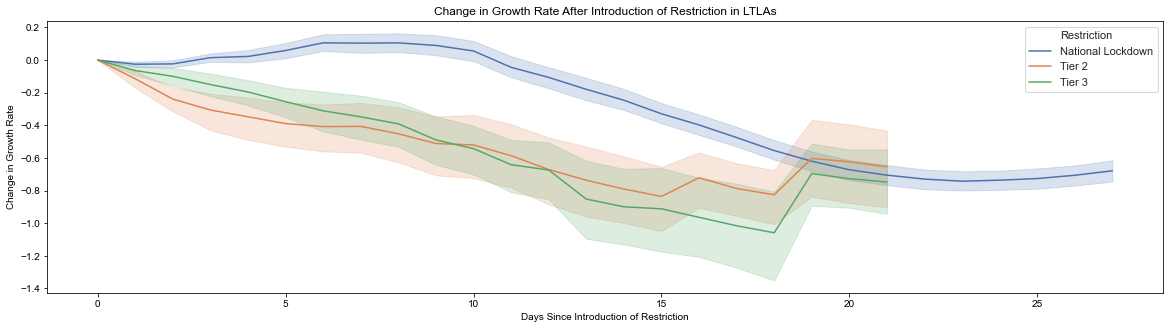

In [89]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
sns.set(style="whitegrid")
# Hack because seaborn doesn't like setting legend for lmplot
filt_growth_rate_delta_data["Restriction"] = "Tier 2"
filt_growth_rate_delta_data.loc[filt_growth_rate_delta_data["tier"] ==  "3", "Restriction"] = "Tier 3"
filt_growth_rate_delta_data.loc[filt_growth_rate_delta_data["tier"] ==  "national_lockdown", "Restriction"] = "National Lockdown"

g = sns.lineplot(x="d_since_tier_change", y="growth_rate_delta", 
               data=filt_growth_rate_delta_data[
                        (filt_growth_rate_delta_data["tier"].isin(["2", "3", "national_lockdown"]))
                    ],
              
               hue="Restriction",
                 ax=axs
               
               
              )


axs.set_ylabel("Change in Growth Rate")
axs.set_xlabel("Days Since Introduction of Restriction")
axs.set_title('Change in Growth Rate After Introduction of Restriction in LTLAs')

plt.show(g)

# Examine Distributions of Potential Response Variables

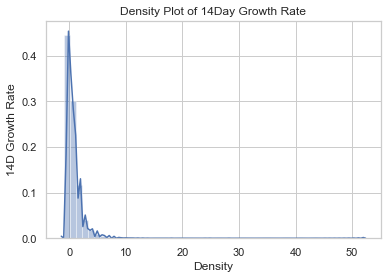

In [90]:
fig, axs = plt.subplots()
sns.distplot(filt_growth_rate_data["growth_rate"], hist=True, kde=True)
axs.set_title("Density Plot of 14Day Growth Rate")
axs.set_xlabel("Density")
axs.set_ylabel("14D Growth Rate")
plt.show()

# GLM Gaussian Model with Growth Rate as Response Variable

Just based on the distribution of the growth rate variable, we suspect that a gaussian family GLM will not fit the data.  But we try it anyway just to check.

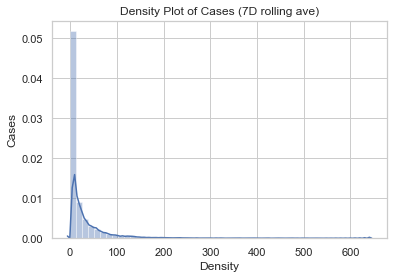

In [91]:
fig, axs = plt.subplots()
sns.distplot(filt_case_data["newCasesBySpecimenDateSmooth"], hist=True, kde=True)
axs.set_title("Density Plot of Cases (7D rolling ave)")
axs.set_xlabel("Density")
axs.set_ylabel("Cases")
plt.show()

In [92]:
# Distro of growth rate is left skewed with long right tail with negative numbers. 
model_growth_rate_gauss = smf.glm(
                    formula="growth_rate ~ d_since_tier_change + newCasesBySpecimenDateSmooth + tier", 
                    data=filt_growth_rate_data,
                   family=sm.families.Gaussian())
model_growth_rate_gauss_fit = model_growth_rate_gauss.fit()
print(model_growth_rate_gauss_fit.summary2())
print("Covariate Pvalues:\n")
print(model_growth_rate_gauss_fit.pvalues)

print("\nBenjamini Hochberg Adjusted Pvalues:\n")
print(smstats.multitest.multipletests(pvals=model_growth_rate_gauss_fit.pvalues, 
                                          alpha=0.05,
                                          method="fdr_bh")[1])


                      Results: Generalized linear model
Model:                  GLM                  AIC:                143551.2666 
Link Function:          identity             BIC:                -356974.9063
Dependent Variable:     growth_rate          Log-Likelihood:     -71770.     
Date:                   2021-05-10 23:55     LL-Null:            -78050.     
No. Observations:       41069                Deviance:           79238.      
Df Model:               5                    Pearson chi2:       7.92e+04    
Df Residuals:           41063                Scale:              1.9297      
Method:                 IRLS                                                 
-----------------------------------------------------------------------------
                              Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------
Intercept                    -0.7607   0.0159 -47.9819 0.0000 -0.7918 -0.7296
tier[T.2

We examine the residuals vs fitted and it's not great.  The residuals are very upwards skewed. This shows that the model does not really fit the data

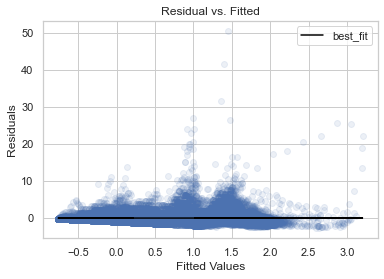

In [93]:
# from https://www.statsmodels.org/stable/examples/notebooks/generated/glm.html
plt.scatter(model_growth_rate_gauss_fit.fittedvalues, model_growth_rate_gauss_fit.resid_pearson, alpha = 0.1) 
plt.title("Residual vs. Fitted")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

m, b = np.polyfit(model_growth_rate_gauss_fit.fittedvalues, model_growth_rate_gauss_fit.resid_pearson, 1)
plt.plot(model_growth_rate_gauss_fit.fittedvalues, 
         m*(model_growth_rate_gauss_fit.fittedvalues) + b,
        label="best_fit", color="black")

plt.legend()
plt.show()

# Gaussian Family Mixed Model With LTLA as Fixed Effects 

In [94]:
model_growthrate_gauss_mixed = smf.mixedlm(
    "growth_rate ~ d_since_tier_change + newCasesBySpecimenDateSmooth + tier",
     filt_growth_rate_data, 
     groups=filt_growth_rate_data["ltla"])
model_growthrate_gauss_mixed_fit = model_growthrate_gauss_mixed.fit()
print(model_growthrate_gauss_mixed_fit.summary())

print("Covariate Pvalues:\n")
print(model_growthrate_gauss_mixed_fit.pvalues)

print("\nBenjamini Hochberg Adjusted Pvalues:\n")
print(smstats.multitest.multipletests(pvals=model_growthrate_gauss_mixed_fit.pvalues, 
                                          alpha=0.05,
                                          method="fdr_bh")[1])

model_growthrate_gauss_mixed_aic = smtools.eval_measures.aic(model_growthrate_gauss_mixed_fit.llf,
                                   model_growthrate_gauss_mixed_fit.nobs,
                                   model_growthrate_gauss_mixed_fit.df_modelwc)
print("\nAIC:\n")
print(model_growthrate_gauss_mixed_aic)

                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      growth_rate
No. Observations:      41069        Method:                  REML       
No. Groups:            310          Scale:                   1.8783     
Min. group size:       62           Log-Likelihood:          -71483.4525
Max. group size:       171          Converged:               Yes        
Mean group size:       132.5                                            
------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                    -0.803    0.021 -38.268 0.000 -0.844 -0.762
tier[T.2]                     0.903    0.038  23.499 0.000  0.827  0.978
tier[T.3]                     0.398    0.063   6.348 0.000  0.275  0.521
tier[T.national_lockdown]     0.458    0.023  19.675 0.000  0.412  0.

We see that the mixed model fixed on LTLA doesn't do better than the general linear model at fitting the data.  The residuals vs fitted is simlar.  Upwards skewed residuals.  

Comparing the AIC of the mixed model vs the glm, we see that the mixed model has a lower AIC and is thus a better fit.  If we had to choose between the two models, we'd choose the mixed model.

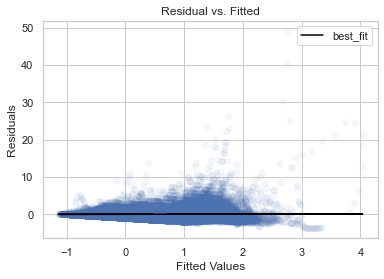

In [95]:
plt.scatter(model_growthrate_gauss_mixed_fit.fittedvalues, 
            model_growthrate_gauss_mixed_fit.resid, alpha = 0.05) 
plt.title("Residual vs. Fitted")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

m, b = np.polyfit(model_growthrate_gauss_mixed_fit.fittedvalues, model_growthrate_gauss_mixed_fit.resid, 1)
plt.plot(model_growthrate_gauss_mixed_fit.fittedvalues, 
         m*(model_growthrate_gauss_mixed_fit.fittedvalues) + b,
        label="best_fit", color="black")

plt.legend()
plt.show()

# Gamma GLM Using Cases as Response

In [96]:
# Distro of cases is left skewed with long right tail.  But uses positive numbers
model_case_gamma = smf.glm(
    formula="newCasesBySpecimenDateSmooth ~ d_since_tier_change + tier + newCasesBySpecimenDateSmooth_at_tier_change", 
    data=filt_case_data,
   family=sm.families.Gamma(link=sm.genmod.families.links.log))
model_case_gamma_fit = model_case_gamma.fit()
print(model_case_gamma_fit.summary2())
print("Covariate Pvalues:\n")
print(model_case_gamma_fit.pvalues)

print("\nBenjamini Hochberg Adjusted Pvalues:\n")
print(smstats.multitest.multipletests(pvals=model_case_gamma_fit.pvalues, 
                                          alpha=0.05,
                                          method="fdr_bh")[1])

/Users/tn6/miniconda3/envs/malariagen-2805ab9/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """
/Users/tn6/miniconda3/envs/malariagen-2805ab9/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:735: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)


                             Results: Generalized linear model
Model:                    GLM                               AIC:                 -inf       
Link Function:            log                               BIC:                 306873.1327
Dependent Variable:       newCasesBySpecimenDateSmooth      Log-Likelihood:      inf        
Date:                     2021-05-10 23:55                  LL-Null:             inf        
No. Observations:         52996                             Deviance:            8.8330e+05 
Df Model:                 5                                 Pearson chi2:        1.85e+05   
Df Residuals:             52990                             Scale:               3.4872     
Method:                   IRLS                                                              
--------------------------------------------------------------------------------------------
                                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------

In [97]:
# Distro of cases is left skewed with long right tail.  But uses positive numbers
model_case_poisson = smf.glm(
    formula="newCasesBySpecimenDateSmooth ~ d_since_tier_change + tier + newCasesBySpecimenDateSmooth_at_tier_change", 
    data=filt_case_data,
   family=sm.families.Poisson(link=sm.genmod.families.links.log))
model_case_poisson_fit = model_case_poisson.fit()
print(model_case_poisson_fit.summary2())
print("Covariate Pvalues:\n")
print(model_case_poisson_fit.pvalues)

print("\nBenjamini Hochberg Adjusted Pvalues:\n")
print(smstats.multitest.multipletests(pvals=model_case_poisson_fit.pvalues, 
                                          alpha=0.05,
                                          method="fdr_bh")[1])

/Users/tn6/miniconda3/envs/malariagen-2805ab9/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """


                            Results: Generalized linear model
Model:                  GLM                              AIC:                1116168.0419
Link Function:          log                              BIC:                372536.1188 
Dependent Variable:     newCasesBySpecimenDateSmooth     Log-Likelihood:     -5.5808e+05 
Date:                   2021-05-10 23:55                 LL-Null:            -1.4693e+06 
No. Observations:       52996                            Deviance:           9.4896e+05  
Df Model:               5                                Pearson chi2:       1.99e+06    
Df Residuals:           52990                            Scale:              1.0000      
Method:                 IRLS                                                             
-----------------------------------------------------------------------------------------
                                            Coef.  Std.Err.    z     P>|z|  [0.025 0.975]
--------------------------------------

In [98]:
model_case_poisson_fit.df_resid

52990

In [99]:
model_case_poisson_fit.deviance

948959.840106628

Examine the pchisq goodness of fitness test that can be used for Poisson GLM.  Here, the null hypothesis is that our model fits our data.  We get nan p-values, which is unexpected.  We also checked in R that the chisq statistic is correct using the same values.  We abondon this approach because the model probably does't fit the data based on the weird fitness results.

Also, based on stats exchange, we abandon use of a residual-fitted values plot to check goodness of fit, since it doesn't apply to Poisson models.
https://stats.stackexchange.com/questions/25068/interpreting-plot-of-residuals-vs-fitted-values-from-poisson-regression

In [100]:

# https://stats.stackexchange.com/questions/25068/interpreting-plot-of-residuals-vs-fitted-values-from-poisson-regression
# https://thestatsgeek.com/2014/04/26/deviance-goodness-of-fit-test-for-poisson-regression/

scipy.stats.chisquare([model_case_poisson_fit.deviance],  ddof=[model_case_poisson_fit.df_resid], axis=None)

Power_divergenceResult(statistic=0.0, pvalue=array([nan]))

# Gamma or Gamma Mixed Model Using Cases as Response and LTLA as Fixed Effect

I wanted to try to do a Poisson Mixed Model or Gamma Mixed Model, but unfortunately, I have run into conda environment dependency issues where we cannot upgrade statsmodel package to the version that supports non-Gaussian families.  An alternative is to use the lmer package in R, which I know supports these models and definitely works.  However, this current conda environment won't let me install R either.  Alas, I have run out of time.

In [101]:
# random = {"a": '0 + C(ltla)'}
# model_growthrate_gamma_mixed = sm.genmod.PoissonBayesMixedGLM.from_formula(
#     formula="newCasesBySpecimenDateSmooth ~ d_since_tier_change + tier + newCasesBySpecimenDateSmooth_at_tier_change",
#      data=filt_case_data, 
#     vc_formulas=random,
#     family=sm.families.Gamma(link=sm.genmod.families.links.log))
# model_growthrate_gamma_mixed_fit = model_growthrate_gamma_mixed.fit()
# print(model_growthrate_gamma_mixed_fit.summary())

# print("Covariate Pvalues:\n")
# print(model_growthrate_gamma_mixed_fit.pvalues)

# print("\nBenjamini Hochberg Adjusted Pvalues:\n")
# print(smstats.multitest.multipletests(pvals=model_growthrate_gamma_mixed_fit.pvalues, 
#                                           alpha=0.05,
#                                           method="fdr_bh")[1])